In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
#import data (March'18-May'18) ffrom MTA turnstile data from(http://web.mta.info/developers/turnstile.html)
SEARCH_TYPE = 'Spring'     # 'None' to suppress this cell
if SEARCH_TYPE=='Spring':  # SMB: files sometimes don't load, so added try: below
    TURNSTILE_PATH = 'http://web.mta.info/developers/data/nyct/turnstile/'
    TURNSTILE_FILES = ['turnstile_180310','turnstile_180317','turnstile_180324','turnstile_180331',
                      'turnstile_180407','turnstile_180414','turnstile_180421','turnstile_180428',
                      'turnstile_180505','turnstile_180512','turnstile_180519','turnstile_180526',
                       'turnstile_180602','turnstile_180609']
    turnstile_files = [TURNSTILE_PATH + x + '.txt' for x in TURNSTILE_FILES]

    tflist = []
    for tf in turnstile_files:
        print(f'Opening file {tf[-20:]}')
        try:
            df = pd.read_csv(tf, index_col=None, header=0)
            tflist.append(df)
        except:
            print(f'  Trouble accessing file -> skipping.')
    data_nyc_turnstile = pd.concat(tflist)
    
#
    data_nyc_turnstile.columns = data_nyc_turnstile.columns.str.replace(' ', '')

else:
    print('MTA data not loaded; "data_nyc_turnstiles" was not refreshed.')

Opening file turnstile_180310.txt
Opening file turnstile_180317.txt
Opening file turnstile_180324.txt
Opening file turnstile_180331.txt
Opening file turnstile_180407.txt
Opening file turnstile_180414.txt
Opening file turnstile_180421.txt
Opening file turnstile_180428.txt
Opening file turnstile_180505.txt
Opening file turnstile_180512.txt
Opening file turnstile_180519.txt
Opening file turnstile_180526.txt
Opening file turnstile_180602.txt
Opening file turnstile_180609.txt


In [5]:
##Including columns for computing date-time series
data_nyc_turnstile['Date_time'] = data_nyc_turnstile['DATE'] + ' ' + data_nyc_turnstile['TIME']

#Converting ['Date_time'] to datetime64 series
data_nyc_turnstile['Datetime'] = pd.to_datetime(data_nyc_turnstile['Date_time'], format="%m/%d/%Y %H:%M:%S")
data_nyc_turnstile.drop('Date_time', axis=1, inplace=True)

#Adding ['Day of the week' in integer form]
data_nyc_turnstile['Day'] = data_nyc_turnstile['Datetime'].dt.dayofweek


In [6]:
##Sorting data to calculate traffic for individual turnstile
data_nyc_turnstile.sort_values(by=['STATION', 'UNIT', 'C/A', 'SCP', 'Datetime'], inplace=True)

In [7]:
###Data in the columns 'Entries' and 'Exits' is cumulative.Finding the total number of entries and exits
data_nyc_turnstile['Entry_diff'] = (data_nyc_turnstile.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                           .diff(periods=-1)) * -1

data_nyc_turnstile['Exit_diff']=(data_nyc_turnstile.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                           .diff(periods=-1)) * -1



In [8]:
## Filtering out outliers and negative values
data_nyc_turnstile = data_nyc_turnstile[(data_nyc_turnstile['Entry_diff'] >= 0)
                & (data_nyc_turnstile['Entry_diff'] < 100000)
                & (data_nyc_turnstile['Exit_diff'] >= 0)
                & (data_nyc_turnstile['Exit_diff'] < 100000)
                & (data_nyc_turnstile['Day'] < 5)]


In [9]:
##Finding total Traffic as sum of Total Entries and Exits
data_nyc_turnstile['Total_Traffic']=data_nyc_turnstile['Entry_diff']+data_nyc_turnstile['Exit_diff']

In [10]:
data_nyc_turnstile.head(5)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Day,Entry_diff,Exit_diff,Total_Traffic
30354,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,03:00:00,REGULAR,13276975,14832142,2018-03-05 03:00:00,0,113.0,384.0,497.0
30355,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,07:00:00,REGULAR,13277088,14832526,2018-03-05 07:00:00,0,1439.0,1477.0,2916.0
30356,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,11:00:00,REGULAR,13278527,14834003,2018-03-05 11:00:00,0,704.0,857.0,1561.0
30357,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,15:00:00,REGULAR,13279231,14834860,2018-03-05 15:00:00,0,1308.0,844.0,2152.0
30358,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,19:00:00,REGULAR,13280539,14835704,2018-03-05 19:00:00,0,496.0,556.0,1052.0


In [15]:
## Sorting data by 'Station' with maximum activity
station_data = data_nyc_turnstile.groupby(['STATION']).sum()
station_data['Station_ID'] = station_data.index
station_data = station_data.sort_values(['Total_Traffic'],ascending=False)
station_data['Idx'] = np.arange(station_data.shape[0]) 
station_data = station_data.set_index('Idx')
station_data.head(4)


,ENTRIES,EXITS,Day,Entry_diff,Exit_diff,Total_Traffic,Station_ID
Idx,,,,,,,
0,1673902920723,1238061680127,82225,11716574.0,9939732.0,21656306.0,34 ST-PENN STA
1,430097080120,403263379569,53637,10621837.0,9485906.0,20107743.0,GRD CNTRL-42 ST
2,712164843413,649357132679,42704,7914560.0,7280717.0,15195277.0,34 ST-HERALD SQ
3,1686315390812,1964831638029,57105,8250793.0,5864155.0,14114948.0,23 ST


In [17]:
#Plotting 15 stations with most traffic
import seaborn as sns
sns.set_style("whitegrid")
station_data = station_data.iloc[:15,:]
station_data

,ENTRIES,EXITS,Day,Entry_diff,Exit_diff,Total_Traffic,Station_ID
Idx,,,,,,,
0,1673902920723,1238061680127,82225,11716574.0,9939732.0,21656306.0,34 ST-PENN STA
1,430097080120,403263379569,53637,10621837.0,9485906.0,20107743.0,GRD CNTRL-42 ST
2,712164843413,649357132679,42704,7914560.0,7280717.0,15195277.0,34 ST-HERALD SQ
3,1686315390812,1964831638029,57105,8250793.0,5864155.0,14114948.0,23 ST
4,338682960489,125018540504,31707,7389166.0,6307822.0,13696988.0,14 ST-UNION SQ
5,1657296358841,1312177490857,41055,6984237.0,6400229.0,13384466.0,TIMES SQ-42 ST
6,1802678800029,1783842041513,80210,7000817.0,5777264.0,12778081.0,FULTON ST
7,1522513807444,1067071018770,39734,6290175.0,4972533.0,11262708.0,42 ST-PORT AUTH
8,629208675627,289720049020,42300,5967376.0,4942910.0,10910286.0,86 ST


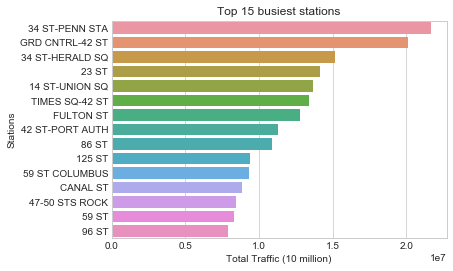

In [18]:
##Plotting a sns plot
sns_plot = sns.barplot(x="Total_Traffic", y='Station_ID', data=station_data)
fig = sns_plot.get_figure()
plt.xlabel("Total Traffic (10 million)")
plt.ylabel("Stations")
plt.title("Top 15 busiest stations")
fig.savefig('top15_high_traffic_stations.png')

In [19]:
##Sorting Data to find the activity by weekday at busiest stations
#Top Station Activity sort by station and day of the week 
station_data_date=data_nyc_turnstile.groupby(['STATION','Day']).sum()
station_data_date.reset_index(inplace=True)

station_data_date.head(3)

,STATION,Day,ENTRIES,EXITS,Entry_diff,Exit_diff,Total_Traffic
0,1 AV,0,252478467391,135259474380,287848.0,314692.0,602540.0
1,1 AV,1,255066163610,136444838964,308181.0,341547.0,649728.0
2,1 AV,2,258556576049,138513599055,307204.0,331466.0,638670.0


Text(0,0.5,'Total Traffic')

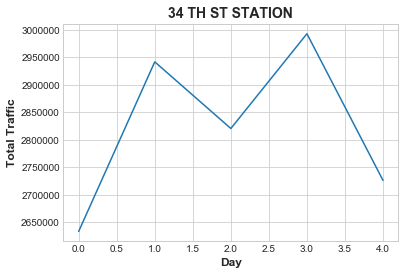

In [20]:
# Graphing activity by day at 34 ST PENN ST (busiest station)
penn_data = station_data_date[station_data_date['STATION'] =='23 ST'] # filter to date by specific station



y = penn_data['Total_Traffic']
x = penn_data['Day in form of integers']

plt.plot(x,y)

plt.title("34 TH ST STATION",fontsize=14,weight='bold')
plt.xlabel('Day', fontsize=12,weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')



Text(0,0.5,'Total Traffic')

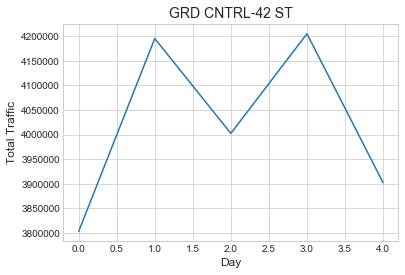

In [124]:
##Grand central station
# Graphing activity by day at GRD CNTRL-42 ST 
grand_central_data = station_data_date[station_data_date['STATION'] =='GRD CNTRL-42 ST'] # filter to date by specific station


#Converting day numbers to days of the week


y = grand_central_data['Total_Traffic']
x = grand_central_data['Day in form of integer']

plt.plot(x,y)

plt.title("GRD CNTRL-42 ST",fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Traffic', fontsize=12)
#plt.gca().set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday'])



Text(0,0.5,'Total Traffic')

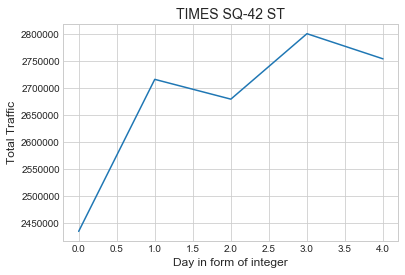

In [22]:
##Times square station
# Graphing activity by day at TIMES SQ-42 ST 
times_data = station_data_date[station_data_date['STATION'] =='TIMES SQ-42 ST'] # filter to date by specific station



y = times_data['Total_Traffic']
x = times_data['Day']

plt.plot(x,y)

plt.title("TIMES SQ-42 ST",fontsize=14)
plt.xlabel('Day in form of integer', fontsize=12)
plt.ylabel('Total Traffic', fontsize=12)

